## Load fill and beam modes

In [2]:
import pytimber
import datetime
import pagestore
import time, calendar
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Retrieve data from database and start analysis

In [133]:
%matplotlib notebook
db=pagestore.PageStore('/home/nbiancac/HDD/Work/MD/LHC/DB/lhc.db','/home/nbiancac/HDD/Work/MD/LHC/DB/')
import LHC_BBQ, LHC_BCT, LHC_Energy, LHC_Coll, LHC_BQM, LHC_BSRT, LHC_FBCT

filln=5130
output_path='/home/nbiancac/HDD/Work/MD/LHC/'+str(filln)+'/'
# os.mkdir(output_path)
tag='scan_6'
beam=1

ts1 = calendar.timegm(time.strptime("2016-07-29 06:46:00","%Y-%m-%d %H:%M:%S"))-2*3600
ts2 = calendar.timegm(time.strptime("2016-07-29 06:59:00","%Y-%m-%d %H:%M:%S"))-2*3600

triggers = db.get("MKQV.UA43.B1.TUNE:TS_TRIGGER",ts1,ts2)['MKQV.UA43.B1.TUNE:TS_TRIGGER']
deltas = np.diff(triggers[1])
index = np.where(deltas != 0)

ts1 = triggers[0][index][-1]
ts2 = ts1 + 2

print datetime.datetime.fromtimestamp(ts1)
print datetime.datetime.fromtimestamp(ts2)


2016-07-29 06:58:56.406000
2016-07-29 06:58:58.406000


In [147]:
BBQ_RAW.v.argmax()

6337

<IPython.core.display.Javascript object>


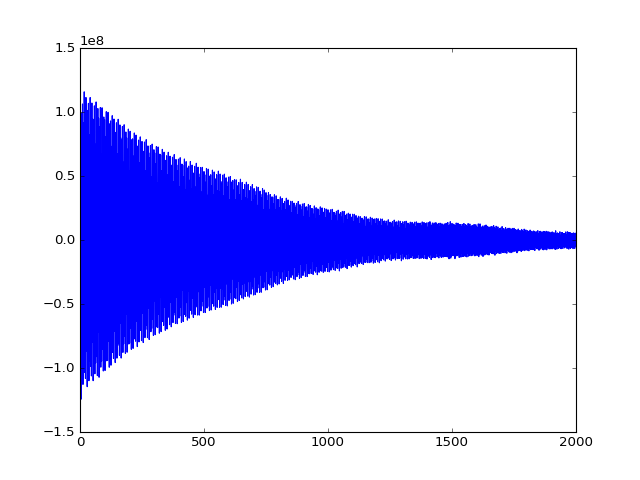

'/home/nbiancac/HDD/Work/MD/LHC/5130/scan_6_raw_B1.pdf'

In [227]:
# RAW BBQ
data=db.get(LHC_BBQ.variable_list_RAW(beams=[beam]),ts1,ts2)
BBQ_RAW=LHC_BBQ.BBQHS_RAW(data,beam=beam)


Nturn=2000
cut = int(round(np.diff(BBQ_RAW.t_stamps[0:2])*11245.5))
BBQ_RAW.v = np.squeeze(BBQ_RAW.v[:,0:cut].reshape(1,-1))
BBQ_RAW.v = BBQ_RAW.v[BBQ_RAW.v.argmax():BBQ_RAW.v.argmax()+Nturn]

plt.figure()
plt.plot(BBQ_RAW.v)
plt.savefig(output_path+tag+'_raw_B'+str(beam)+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_raw_B'+str(beam)+'.png', transparent=True)
output_path+tag+'_raw_B'+str(beam)+'.pdf'

<IPython.core.display.Javascript object>


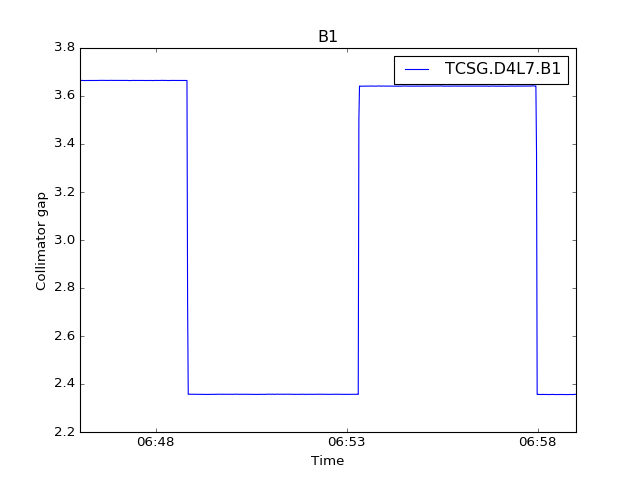

'/home/nbiancac/HDD/Work/MD/LHC/5130/scan_6_gap_B1.pdf'

In [209]:
# Collimators
ts1 = calendar.timegm(time.strptime("2016-07-29 06:46:00","%Y-%m-%d %H:%M:%S"))-2*3600
ts2 = calendar.timegm(time.strptime("2016-07-29 06:59:00","%Y-%m-%d %H:%M:%S"))-2*3600

data=db.get(LHC_Coll.variable_list(beam),ts1,ts2)

Coll=LHC_Coll.Coll(data,beam=beam)
typecoll=['L','R']
namecoll = 'TCSG.D4'+typecoll[beam-1]+'7.B'+str(beam)
Coll.select_coll(namecoll+':MEAS_LVDT_GU')

plt.figure()
plt.plot(Coll.t_str, Coll.values, "-b")
plt.xlabel("Time")
plt.ylabel("Collimator gap")
plt.title('B%d'%(Coll.beam))
plt.legend([namecoll])
xfmt = mpl.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)

plt.savefig(output_path+tag+'_gap_B'+str(beam)+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_gap_B'+str(beam)+'.png', transparent=True)
output_path+tag+'_gap_B'+str(beam)+'.pdf'

### Sussix

In [200]:
import PySussix as ps

# Sussix settings
Nturn=256
nharm = 15

tunex0 = 0.27
tuney0 = 0.295
ex0 = 1e-3
ey0 = 1e-3

tuney_vec=[];tunex_vec=[];
spec_ox=[]; spec_oy=[];
spec_ax=[]; spec_ay=[];
spec_t=[];

for ii in np.arange(0, len(index[0])):
    
    ts1 = triggers[0][index][ii]
    ts2 = ts1 + 2

    data=db.get(LHC_BBQ.variable_list_RAW(beams=[beam]),ts1,ts2)
    BBQ_RAW=LHC_BBQ.BBQHS_RAW(data,beam=beam)


    cut = int(round(np.diff(BBQ_RAW.t_stamps[0:2])*11245.5))
    BBQ_RAW.v = np.squeeze(BBQ_RAW.v[:,0:cut].reshape(1,-1))
    BBQ_RAW.v = BBQ_RAW.v[BBQ_RAW.v.argmax():BBQ_RAW.v.argmax()+Nturn]

    BBQ_RAW.h = np.squeeze(BBQ_RAW.h[:,0:cut].reshape(1,-1))
    BBQ_RAW.h = BBQ_RAW.h[BBQ_RAW.v.argmax():BBQ_RAW.v.argmax()+Nturn]
    
    datax=BBQ_RAW.h-np.mean(BBQ_RAW.h)
    datay=BBQ_RAW.v-np.mean(BBQ_RAW.v)
    
    spec=ps.Sussix()
    spec.sussix_inp(nt1=1,nt2=Nturn,tunex=tunex0,tuney=tuney0,ex=ex0,ey=ey0,ir=1,nharm=nharm)
    spec.sussix(datax,0*datax, 
                datay, 0*datay, 
                0*datax, 0*datay)
    

    
    spec.ox=np.abs(spec.ox)
    spec.oy=np.abs(spec.oy)
    
    spec_ox.append(spec.ox[0:nharm-1])
    spec_oy.append(spec.oy[0:nharm-1])
    spec_ax.append(spec.ax[0:nharm-1])
    spec_ay.append(spec.ay[0:nharm-1])
    spec_t.append(ts1)
    
    del(datax,datay)

<IPython.core.display.Javascript object>


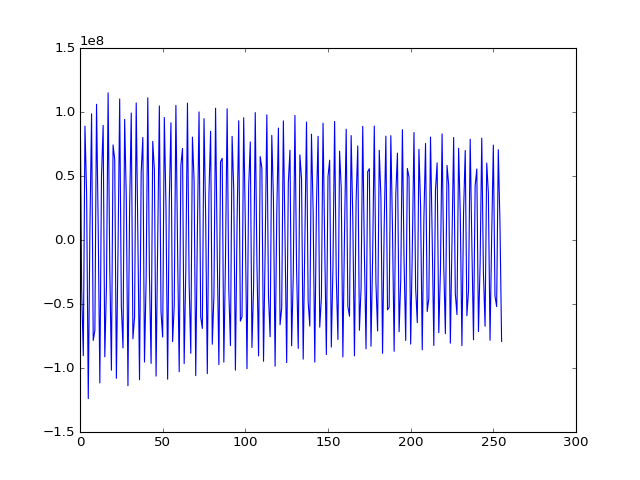

In [201]:
plt.figure()
plt.plot(BBQ_RAW.v)

<IPython.core.display.Javascript object>


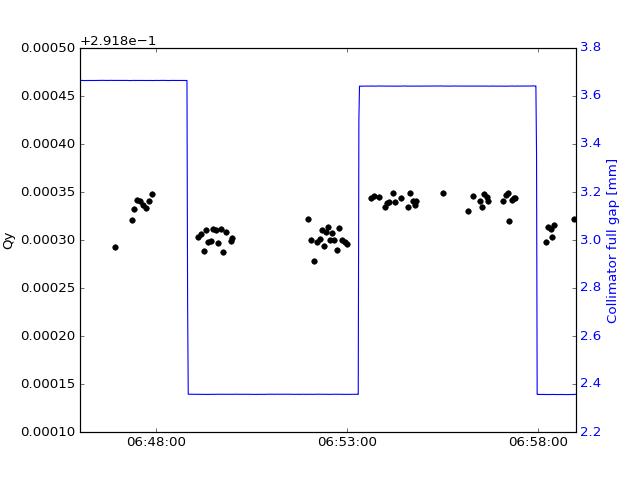

'/home/nbiancac/HDD/Work/MD/LHC/5130/scan_6_sussix_B1.pdf'

In [211]:
[tunex_min, tunex_max] = np.sort([0.261 , 0.27])
[tuney_min, tuney_max] = np.sort([0.2919+0.00013 , 0.2918+0.00035])

rangex=np.array([tunex_min, tunex_max])
rangey=np.array([tuney_min, tuney_max])

tuney_vec=[]

for ii,index2 in enumerate((np.abs(spec_oy) < rangey.max()) & (np.abs(spec_oy) > rangey.min())):
    spec.oy = np.squeeze(spec_oy[ii])[index2]
    spec.ay = np.squeeze(spec_ay[ii])[index2]
    
    if len(spec.ay):
        tuney=spec.oy[spec.ay.argmax()]
    else:
        tuney=np.NaN
    tuney_vec.append(tuney)

BBQ_RAW.qv=np.array(tuney_vec)

tunex_vec=[]

for ii,index2 in enumerate((np.abs(spec_ox) < rangex.max()) & (np.abs(spec_ox) > rangex.min())):
    spec.ox = np.squeeze(spec_ox[ii])[index2]
    spec.ax = np.squeeze(spec_ax[ii])[index2]
    
    if len(spec.ax):
        tunex=spec.ox[spec.ax.argmax()]
    else:
        tunex=np.NaN
    tunex_vec.append(tunex)

BBQ_RAW.qh=np.array(tunex_vec)

t_stamp = np.squeeze(np.reshape(np.asarray(spec_t),(1,-1)))
t_str = [datetime.datetime.fromtimestamp(x) for x in t_stamp]

plt.figure()
ax1 = plt.subplot(1,1,1)
# plt.plot(t_str,np.squeeze(np.reshape(np.asarray(spec_oy),(1,-1))),'ok',alpha=0.2,markerfacecolor='k',markersize=2)
plt.plot(t_str,BBQ_RAW.qv,'ok',alpha=1,markerfacecolor='k', markersize=5)
plt.ylabel('Qy')
plt.ylim(0.2919 ,0.2923)
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(Coll.t_str, Coll.values, 'b-')
ax2.set_xlabel('time')
ax2.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M:%S')
ax2.xaxis.set_major_formatter(xfmt)

plt.savefig(output_path+tag+'_sussix_B'+str(beam)+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_sussix_B'+str(beam)+'.png', transparent=True)
output_path+tag+'_sussix_B'+str(beam)+'.pdf'

### Interpolate gaps on tune data

In [226]:
ind_u = np.where((np.array(t_str) < datetime.datetime(2016, 7, 29, 6, 58, 0, 0)) &
         (np.array(t_str) > datetime.datetime(2016, 7, 29, 6, 53, 26, 0)))

BBQ_RAW.qv[ind_u[0]]

ind_d = np.where((np.array(t_str) > datetime.datetime(2016, 7, 29, 6, 48, 49, 0)) &
         (np.array(t_str) < datetime.datetime(2016, 7, 29, 6, 53, 21, 0)))

tu = np.nanmean(BBQ_RAW.qv[ind_u[0]])
td = np.nanmean(BBQ_RAW.qv[ind_d[0]])

print tu-td

err_tu = np.nanstd(BBQ_RAW.qv[ind_u[0]]-tu)
err_td = np.nanstd(BBQ_RAW.qv[ind_d[0]]-td)

print tu-td,np.sqrt(err_tu**2+err_td**2)

3.94161150356e-05
3.94161150356e-05 1.08986814668e-05


In [199]:
# Get rid of the nans...
ind_nan=~np.isnan(BBQ_RAW.qh) & ~np.isnan(BBQ_RAW.qv)
temp_h=BBQ_RAW.qh[ind_nan]
temp_v=BBQ_RAW.qv[ind_nan]

BBQ_RAW.qh=temp_h;
BBQ_RAW.qv=temp_v;
BBQ_RAW.t_stamps= t_stamps



# Interpolate collgaps on BBQ timestamps
Coll.interp_with(BBQ_RAW)
len(Coll.t_str), len(t_str)

(13, 86)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.plot(Coll.t_str, Coll.values, 'b-')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qh,  'ok',alpha=0.2,markerfacecolor='k',markeredgecolor='k')
ax2.set_ylabel('$Q_x$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangex.min(), rangex.max())
ax2.legend(['B'+str(beam)+'H'])

ax1 = plt.subplot(2,1,2)
ax1.plot(Coll.t_str, Coll.values, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qv,  'or',alpha=0.2,markerfacecolor='r',markeredgecolor='r')
ax2.set_ylabel('$Q_y$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangey.min(), rangey.max())
ax2.legend(['B'+str(beam)+'V'])

plt.savefig(output_path+tag+'_sussix-clean_B'+str(beam)+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_sussix-clean_B'+str(beam)+'.png', transparent=True)
output_path+tag+'_sussix-clean_B'+str(beam)+'.pdf'

### Moving average

In [ ]:
N=250

BBQ_RAW.qv_ma=np.convolve(np.ravel(BBQ_RAW.qv), np.ones((N,))/N,mode='same')

BBQ_RAW.qh_ma=np.convolve(np.ravel(BBQ_RAW.qh), np.ones((N,))/N,mode='same')

Coll.values_ma=np.convolve(np.ravel(Coll.values), np.ones((N,))/N,mode='same')

fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Coll', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qh, 'k.')
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qh_ma, '-r')
ax2.set_ylabel('$Q_x$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangex.min(), rangex.max())

fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Coll', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qv, 'r.')
ax2.plot(BBQ_RAW.t_str, BBQ_RAW.qv_ma, '-k')
ax2.set_ylabel('$Q_y$', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangey.min(), rangey.max())



In [ ]:
gu=0.95*Coll.values.max();
gd=1.05*Coll.values.min()

mask=(Coll.values_ma>gu) & (Coll.values_ma< Coll.values.max())

fig, ax1 = plt.subplots()
ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('halfgap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)

ax2 = ax1.twinx()
ax2.plot(np.array(BBQ_RAW.t_str)[mask], BBQ_RAW.qv_ma[mask], 'r.')
ax2.set_ylabel('BBQ', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.ylim(rangey.min(), rangey.max())

mask=(Coll.values_ma<gd) & (Coll.values_ma> Coll.values.min())
ax2.plot(np.array(BBQ_RAW.t_str)[mask], BBQ_RAW.qv_ma[mask], 'r.')

### Final plots

In [ ]:
gu=0.95*Coll.values.max();
gd=1.05*Coll.values.min()
plane='V'

# get out slope from measurement
x=BBQ_RAW.t_stamps
y=BBQ_RAW.qv

mask_tune=(y<tuney_max) & (y>tuney_min)
p=np.polyfit(x[mask_tune],y[mask_tune],1)
slope=p[0]
intercept=p[1]
fit=slope*x+intercept

plt.figure()
plt.plot(BBQ_RAW.t_stamps,BBQ_RAW.qv)
plt.plot(BBQ_RAW.t_stamps[mask_tune],fit[mask_tune])
plt.ylim(tuney_min, tuney_max)

# Upper gap
mask1=(Coll.values>gu) 
x=BBQ_RAW.t_stamps[mask1]
y=BBQ_RAW.qv[mask1]
fit1=fit[mask1]

mask_tune=(y<tuney_max) & (y>tuney_min)

y1=y-fit1
y1_mean=np.mean(y1[mask_tune])
y1_std=np.std(y1[mask_tune])

# Lower gap
mask2=(Coll.values_ma<gd) 
x=BBQ_RAW.t_stamps[mask2]
y=BBQ_RAW.qv_ma[mask2]

fit2=fit[mask2]
mask_tune=(y<tuney_max) & (y>tuney_min)

y2=y-fit2
y2_mean=np.mean(y2[mask_tune])
y2_std=np.std(y2[mask_tune])

ts_mean=y1_mean- y2_mean
ts_std=y1_std+y2_std

plt.figure(figsize=(10,5), facecolor='white')
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
h2, = ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)
ax1.annotate('$\Delta Q_'+plane+'$= %.1e+/-%.1e'%(ts_mean,ts_std),xy=(Coll.t_str[5], Coll.values_ma[5]))
plt.title(tag.replace('_',' ')+' B'+str(beam)+plane)
ax2 = ax1.twinx()
h0, = ax2.plot(np.array(BBQ_RAW.t_str)[mask1], y1, 'or',alpha=0.5,markerfacecolor='r',markeredgecolor='r')
h1, = ax2.plot(np.array(BBQ_RAW.t_str)[mask2][mask_tune], y2[mask_tune], 'ok',alpha=.5,markerfacecolor='k',markeredgecolor='k')
ax2.set_ylim(-2.5e-4, 2.5e-4)
ax2.yaxis.set_ticks([])

plt.legend([h0, h1, h2],['$Q_'+plane+'$ gap up' , '$Q_'+plane+'$ gap down', 'Collimator full gap'])


# distribution
ax1 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax1.set_ylim(-2.5e-4, 2.5e-4)
ax1.yaxis.set_ticks([])
ax1.xaxis.set_ticks([])

ax2=ax1.twinx()
n, bins, patches = plt.hist(y1, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='r', alpha=0.75, orientation="horizontal")
n, bins, patches = plt.hist(y2, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='k', alpha=0.75, orientation="horizontal")
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks([-2e-4, -1e-4, 0, 1e-4, 2e-4])
ax2.set_ylabel('$\Delta Q_'+plane+'$')
ax2.set_ylim(-2.5e-4, 2.5e-4)
plt.tight_layout()


print '%.1e+/-%.1e'%(y1_mean,y1_std)
print '%.1e+/-%.1e'%(y2_mean,y2_std)
print 'tune shift: %.1e+/-%.1e'%(ts_mean,ts_std)

plt.savefig(output_path+tag+'_tune_vs_gap_B'+str(beam)+plane+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_tune_vs_gap_B'+str(beam)+plane+'.png', transparent=True)
output_path+tag+'_tune_vs_gap_B'+str(beam)+plane+'.pdf'

In [ ]:
gu=0.95*Coll.values.max();
gd=1.05*Coll.values.min()
plane='H'

# get out slope from measurement
x=BBQ_RAW.t_stamps
y=BBQ_RAW.qh_ma

mask_tune=(y<tunex_max) & (y>tunex_min)
p=np.polyfit(x[mask_tune],y[mask_tune],1)
slope=p[0]
intercept=p[1]
fit=slope*x+intercept

plt.figure()
plt.plot(BBQ_RAW.t_stamps,BBQ_RAW.qh_ma)
plt.plot(BBQ_RAW.t_stamps[mask_tune],fit[mask_tune])
plt.ylim(tunex_min, tunex_max)

# Upper gap
mask1=(Coll.values_ma>gu) 
x=BBQ_RAW.t_stamps[mask1]
y=BBQ_RAW.qh_ma[mask1]
fit1=fit[mask1]

mask_tune=(y<tunex_max) & (y>tunex_min)

y1=y-fit1
y1_mean=np.mean(y1[mask_tune])
y1_std=np.std(y1[mask_tune])

# Lower gap
mask2=(Coll.values_ma<gd) 
x=BBQ_RAW.t_stamps[mask2]
y=BBQ_RAW.qh_ma[mask2]

fit2=fit[mask2]
mask_tune=(y<tunex_max) & (y>tunex_min)

y2=y-fit2
y2_mean=np.mean(y2[mask_tune])
y2_std=np.std(y2[mask_tune])

ts_mean=y1_mean- y2_mean
ts_std=y1_std+y2_std

plt.figure(figsize=(10,5), facecolor='white')
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
h2, = ax1.plot(Coll.t_str, Coll.values_ma, 'b-')
ax1.set_xlabel('time')
ax1.set_ylabel('Collimator full gap [mm]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
xfmt = mpl.dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(xfmt)
ax1.annotate('$\Delta Q_'+plane+'$= %.1e+/-%.1e'%(ts_mean,ts_std),xy=(Coll.t_str[5], Coll.values_ma[5]))
plt.title(tag.replace('_',' ')+' B'+str(beam)+plane)
ax2 = ax1.twinx()
h0, = ax2.plot(np.array(BBQ_RAW.t_str)[mask1], y1, 'or',alpha=0.5,markerfacecolor='r',markeredgecolor='r')
h1, = ax2.plot(np.array(BBQ_RAW.t_str)[mask2][mask_tune], y2[mask_tune], 'ok',alpha=.5,markerfacecolor='k',markeredgecolor='k')
ax2.set_ylim(-2.5e-4, 2.5e-4)
ax2.yaxis.set_ticks([])

plt.legend([h0, h1, h2],['$Q_'+plane+'$ gap up' , '$Q_'+plane+'$ gap down', 'Collimator full gap'])



# distribution
ax1 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax1.set_ylim(-2.5e-4, 2.5e-4)
ax1.yaxis.set_ticks([])
ax1.xaxis.set_ticks([])

ax2=ax1.twinx()
n, bins, patches = plt.hist(y1, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='r', alpha=0.75, orientation="horizontal")
n, bins, patches = plt.hist(y2, 100, range = (-2.5e-4, 2.5e-4), normed=1, facecolor='k', alpha=0.75, orientation="horizontal")
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks([-2e-4, -1e-4, 0, 1e-4, 2e-4])
ax2.set_ylabel('$\Delta Q_'+plane+'$')
ax2.set_ylim(-2.5e-4, 2.5e-4)
plt.tight_layout()


print '%.1e+/-%.1e'%(y1_mean,y1_std)
print '%.1e+/-%.1e'%(y2_mean,y2_std)
print 'tune shift: %.1e+/-%.1e'%(ts_mean,ts_std)

plt.savefig(output_path+tag+'_tune_vs_gap_B'+str(beam)+plane+'.pdf', transparent=True)
plt.savefig(output_path+tag+'_tune_vs_gap_B'+str(beam)+plane+'.png', transparent=True)
output_path+tag+'_tune_vs_gap_B'+str(beam)+plane+'.pdf'